# ADM reconstruction

In [1]:
import torch
import numpy as np
from DynapSEtorch.model import ADM as ADMtorch
from DynapSEtorch.datasets.EMG import RoshamboDataset
from torch.optim import Adamax, SGD

from tqdm import trange
import matplotlib.pyplot as plt

We initialize the dataset that we are going to use to optimize the ADM encoder.

In [2]:
dataset = RoshamboDataset("~/Work/datasets", upsample=5)  # 5 ~ dt=1ms
n_batch = 128
emg = []
for i in range(n_batch):
    kk, _ = dataset[i]
    emg.append(kk)
emg = torch.stack(emg, dim=0)

We created the ADM encoder and the optimizer for "learning" the ADM UP and DOWN thresholds

In [3]:
encoder = ADMtorch(8, 0.9, 0.9, 0)
optimizer = SGD(encoder.parameters(), lr=1e-4)

pbar = trange(100)
for epoch in pbar:
    spikes = []
    emg = emg.detach()
    encoder.refrac = None
    encoder.DC_Voltage = None
    for t in range(emg.shape[1]):
        o, o_p, o_n = encoder(emg[:, t])
        spikes.append(o)
    spikes = torch.stack(spikes, dim=1)

    rec = encoder.reconstruct(spikes, initial_value=emg[:, 0, :].detach())

    loss = torch.mean((rec - emg.detach()) ** 2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_postfix(
        loss=loss.item(),
        threshold_up=encoder.threshold_up.item(),
        threshold_down=encoder.threshold_down.item(),
    )

100%|██████████| 100/100 [01:00<00:00,  1.65it/s, loss=528, threshold_down=0.963, threshold_up=0.932]


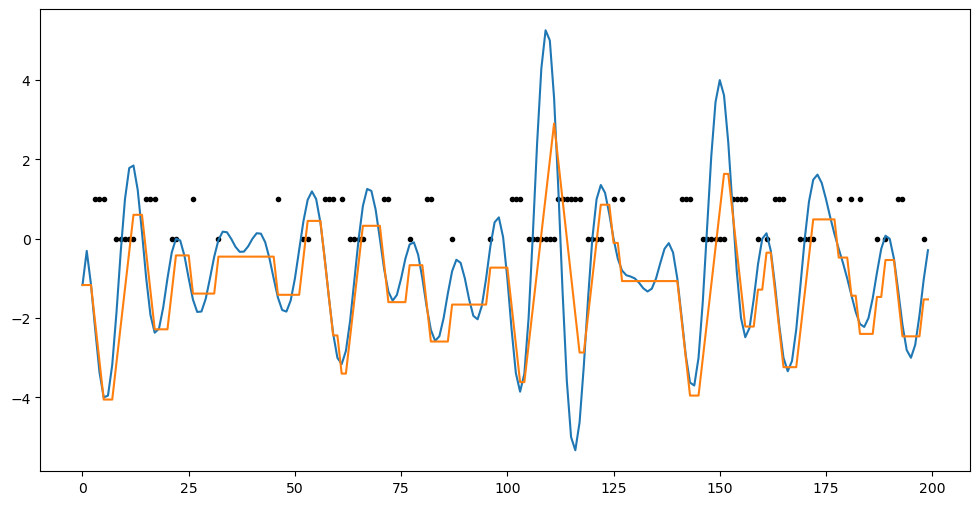

In [4]:
batch = 2
t, idx = np.where(spikes[batch, :, [0, 8]].detach().numpy())

plt.figure(figsize=(12, 6))
plt.plot(emg[batch][:, 0].detach().numpy())
plt.plot(rec[batch][:, 0].detach().numpy())
plt.scatter(t, idx, marker=".", color="k")
plt.show()

In [5]:
encoder.threshold_down

Parameter containing:
tensor(0.9629, requires_grad=True)

In [6]:
encoder.threshold_up

Parameter containing:
tensor(0.9321, requires_grad=True)